# Segmentation Training

Contains: 
- Tranfer Learning Pipeline for all segmentation models

### Import Packages

In [1]:
import segmentation_models_pytorch as smp
import sys
sys.path.insert(0, '..')
from evaluation.metrics_tumor import * 
from slide.process_slides import *
from slide.pytorch_helper import *
from slide.pytorch_augmentations import *
from slide.new_pytorch_buildings_dataset import *
from slide.unet_model import *
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import albumentations as album
from fastai.vision import *
import time
from torch.utils.tensorboard import SummaryWriter
import datetime

### Define dataset type

In [2]:
#choose dataset type
dataset_type = "scc_tumor_segmentation"
# dataset_type = "mammaCA_tumor_segmentation" #- only here check for tumor id
# dataset_type = "tubule_formation_segmentation"
# dataset_type = "pleomorphism_segmentation"

### Set Hyperparameters

In [3]:
image_folder = "../Data/crops_rescaled"
annotations_file = "../Data/CMC_Tumor_Tub_Pleo.json"
csv_path =  "../Data/datasets.csv"
level = 0
down_factor = 4
patch_size =  512 
num_patches_valid = 10 
width = patch_size
height= patch_size
epochs = 25 
log_interval = 55
lr = 0.001 
resize = False

only_valid = True
staining = False
white_mask_application = True
transfer_learning = False
binary = False
#string for log in tensorboard
date_time = datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")

if dataset_type == "scc_tumor_segmentation" or dataset_type == "mammaCA_tumor_segmentation": 
    batch_size =  7
    only_train_head = False
    label_dict = {'Other':0, 'Bg':1,'Tumor': 2, 'KeinTumor': 3}
    reduced_label_dict = {'Tumor': 2, 'KeinTumor': 3}
    num_classes = 4
    if dataset_type == "scc_tumor_segmentation":
        epochs = 25
        batch_size =  7
        label_dis = [0.5, 0.5]
        valid_dis = [0.5, 0.5]
        staining = True
        level = 0 
        num_patches= 50 
        num_patches_valid = 50 
        image_folder = "../Data/SCC_images"
        annotations_file = '../Data/CATCH_Daten/SCC_Tumor_NonTumor.json'
        csv_path =  "../Data/SCC_datasets.csv"
        tumor_id =  11
        resize = True 
        patch_size =  512
        load_pretrained = False
        change_output_layer = False
        only_valid = True
        pretrained_model = "../CanineMammaryTumors/segmentation/models/CATCH_segmentation_model_modified.pth"
        lr = 0.001
        momentum= 0.9
        weight_decay=0.007
        set_dropout = False
        optimizer = "sgd"
        # optimizer = "adam"

        comment = "level: ", level, "num patches: ", num_patches, "lr: ", lr, "staining: ", staining, "stain: ", staining, "white mask: ", white_mask_application, "SGD, momentum 0.9 und CE Loss"
        dir = "../CanineMammaryTumors/segmentation/SCC_runs", date_time
        alpha = 1 
        beta = 0.5 
        criterion = smp.losses.FocalLoss(mode = 'multiclass', reduction= "mean", ignore_index=0, gamma=2)

    if dataset_type == "mammaCA_tumor_segmentation":
        batch_size = 7
        num_patches= 7
        num_patches_valid =  7
        label_dis = [0.5, 0.5]
        valid_dis = [0.5, 0.5]
        
        lr = 0.0005
        momentum= 0.95
        weight_decay=0.003
        staining = True
        tumor_id =  2
        load_pretrained = True
        change_output_layer = False
        transfer_learning = True
        pretrained_model = "../CanineMammaryTumors/segmentation/best_models_final/best_scc_tumor_segmentation_model_level_1_09_03.pth"
        comment = "level: ", level, "num patches: ", num_patches, "lr: ", lr, "staining: ", staining, "stain: ", staining, "white mask: ", white_mask_application, "SGD, momentum 0.9 und CE Loss"
        dir = "../CanineMammaryTumors/segmentation/MammaCA_runs", date_time
        optimizer = "sgd"
        criterion = nn.CrossEntropyLoss(ignore_index=0, reduction="mean") 
        alpha = 1 #focal/ce
        beta = 0.3 #iou


if dataset_type == "tubule_formation_segmentation" or dataset_type == "pleomorphism_segmentation": 
    lr = 0.001
    momentum= 0.9
    batch_size =  11
    weight_decay= 0.001
    num_patches = 5
    num_patches_valid = 5
    load_pretrained = True
    change_output_layer = False
    only_train_head = True
    
    pretrained_model = "../CanineMammaryTumors/segmentation/best_models_final/best_mammaCA_tumor_segmentation_model_level_1_12_03_23.pth"
    if dataset_type == "tubule_formation_segmentation": 
        white_mask_application = False
        binary = False
        label_dis = [0,1]
        valid_dis = [0,1] 
        label_dict = {'Other':0, 'Tubular': 1} 
        reduced_label_dict = {'Other':0,'Tubular': 1}
        num_classes = 2
        comment = "level: ", level, "num patches: ", num_patches, "lr: ", lr
        dir = "../CanineMammaryTumors/segmentation/Tub_runs", date_time
        optimizer = "sgd"
        criterion = nn.CrossEntropyLoss(reduction="mean")
        alpha = 0.7 #focal/ce
        beta = 0.3 #iou
    if dataset_type == "pleomorphism_segmentation": 
        pretrained_model = "../CanineMammaryTumors/segmentation/best_models_final/best_mammaCA_tumor_segmentation_model_level_1_12_03_23.pth" #hat am anfang gut gestartet aber mit 0.001 overfittet
        white_mask_application = True
        label_dis = [0,0,0.8,0.5, 0.7]
        valid_dis = [0,0,1, 1, 1]
        label_dict = {'Other':0, 'Bg':1,'Pleo1': 2, 'Pleo2': 3, 'Pleo3':4} 
        reduced_label_dict = {'Other':0, 'Bg':1,'Pleo1': 2, 'Pleo2': 3, 'Pleo3': 4} 
        num_classes = 5
        comment = "level: ", level, "num patches: ", num_patches, "lr: ", lr
        dir = "../CanineMammaryTumors/segmentation/Pleo_runs", date_time
        optimizer = "sgd"
        criterion = smp.losses.FocalLoss(mode = 'multiclass', reduction= "mean",gamma=4)
        alpha = 1 #focal/ce
        beta = 0.2 #iou

### DB supercategories for different tasks

In [4]:
if dataset_type == "tubule_formation_segmentation":
    poly_klasse = "tub_id"
    name = 'supercategory_TubFormation'
    id = 'id_super_tub'
    tumor_id = None 

if dataset_type == "pleomorphism_segmentation":
    poly_klasse = "pleo_id"
    name = 'supercategory_Pleo'
    id = 'id_super_pleo'
    tumor_id = None 

if dataset_type == "scc_tumor_segmentation": 
    poly_klasse = "tumor_id"
    name = 'supercategory_1'
    id = 'id_super'
    tumor_id = tumor_id 

if dataset_type == "mammaCA_tumor_segmentation": 
    poly_klasse = "tumor_id"
    name = 'supercategory_1'
    id = 'id_super'
    tumor_id = tumor_id 

In [5]:
# class_rgb values 
# Get RGB values of required classes
select_class_rgb_values =  [[v] for k,v in label_dict.items()]

print('Selected classes and their corresponding RGB values in labels:')
print('Class RGB values: ', select_class_rgb_values)
print("dataset type = ", dataset_type)

Selected classes and their corresponding RGB values in labels:
Class RGB values:  [[0], [1], [2], [3]]
dataset type =  scc_tumor_segmentation


### Load Train, Valid Files as Lists

In [6]:
train_files, valid_files, _= load_slides(["train","valid", "test"], target_folder = image_folder, csv_path = csv_path, annotations_file = annotations_file, label_dict = reduced_label_dict, dataset_type = dataset_type)
train_data = create_patches(train_files, patches_per_slide=num_patches)
valid_data = create_patches(valid_files, patches_per_slide=num_patches_valid)

100%|██████████| 50/50 [00:00<00:00, 263461.31it/s]


### Transformations (augmentation, preprocessing)

In [7]:
#training transformations
albumentations_transform_train = album.Compose([
    #augmentations
    album.OneOf([
        album.HorizontalFlip(p=1),
        album.VerticalFlip(p=1),
        album.RandomRotate90(p=1),
    ], p=0.75,),
    
    album.OneOf([
        album.OpticalDistortion(p=0.3),
        album.GridDistortion(p=.1),
        album.IAAPiecewiseAffine(p=0.3),
    ], p=0.75),

    #staining is applied in other funktion
    
    album.Normalize(
        mean=[0.7587, 0.5718, 0.6572],
        std=[0.0866, 0.1118, 0.0990],
    ),
])

#valid transformations
albumentations_transform_valid = album.Compose([
    album.Normalize(
        mean=[0.7587, 0.5718, 0.6572],
        std=[0.0866, 0.1118, 0.0990],
    ),
])

### Visualize Patches and Area distribution

In [8]:
dataset = BuildingsDataset(
        image_paths = train_data,  
        annotations_file = annotations_file,
        num_patches= 1,
        class_rgb_values=select_class_rgb_values, 
        reduced_label_dict = reduced_label_dict,
        patch_size = patch_size,
        label_dict = label_dict,
        transform = None, 
        staining=False, 
        level = level,
        white_mask_application = white_mask_application,  
        poly_klasse = poly_klasse,
        tumor_id = tumor_id, 
        label_dis = label_dis,
        slide_resize = resize)

In [9]:
#calculate distribution of areas in sampled dataset
unique_elements = []
counts_elements = []
label_dict_pixels = {value:0 for key, value in label_dict.items()}

for i in range(0, len(dataset)-1):
    #get mask array
    _, mask = dataset[i]
    one_hot_encoded_mask = reverse_one_hot(mask)
    unique_values = list(np.unique(one_hot_encoded_mask, return_counts=True)[0])
    values_count = list(np.unique(one_hot_encoded_mask, return_counts=True)[1])
    counts_dict = {unique_values[i]:values_count[i] for i in range(0, len(unique_values))} 

    for label, counts in label_dict_pixels.items():

        if label in list(counts_dict.keys()): 
            label_dict_pixels[label] = counts_dict[label] + counts
    
print("label_dict_pixels: ", label_dict_pixels) 
all_sum = sum(list(label_dict_pixels.values())) 
print("label_dict_pixels percent: ", {label: round((pixel/all_sum), 2) for label, pixel in label_dict_pixels.items()})

label_dict_pixels:  {0: 19172996, 1: 200437571, 2: 96841045, 3: 142038244}
label_dict_pixels percent:  {0: 0.04, 1: 0.44, 2: 0.21, 3: 0.31}


In [10]:
list(np.unique(one_hot_encoded_mask, return_counts=True)[1])

[3620, 126351, 132173]

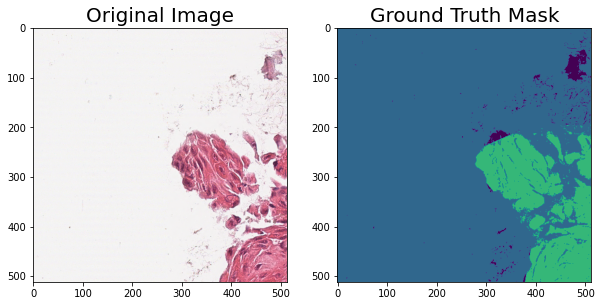

In [11]:
#visualize example patches 
image, mask = dataset[33]
maske = mask[3]
one_hot_encoded_mask = reverse_one_hot(mask)
 
visualize(
    areas=None,
    max_values=None,
    dict = label_dict,
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask),select_class_rgb_values), 
)

[0.0, 1.0, 2.0, 3.0]


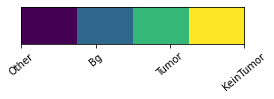

In [12]:
# plot color information
plt.figure(figsize=(num_classes,5))
bounds = list(range(0, len(label_dict)))
ax = plt.subplot()
fig = plt.imshow(np.array([[v for k,v in label_dict.items()]]), vmin=0, vmax=len(label_dict)-1, cmap='viridis',  extent=[0,len(label_dict)-1,0,0.5])
div = num_classes/ len(label_dict)
t = round(-1* div,2)
ticks = []
for i in range(0, len(label_dict)): 
    t = t+div
    ticks.append(t)
print(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels([k for k,v in label_dict.items()], rotation = 40) 
plt.yticks([])
plt.show()


## Get Train/Valid DataLoaders

#### Preprocessing with White Mask

In [13]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(train_data, 
annotations_file,
num_patches,
select_class_rgb_values,
patch_size = patch_size,
label_dict = label_dict,
reduced_label_dict = reduced_label_dict,
transform= albumentations_transform_train,
staining=staining,
level = level,
white_mask_application =white_mask_application,  
poly_klasse = poly_klasse,
tumor_id = tumor_id,
label_dis = label_dis,
slide_resize = resize)

valid_dataset = BuildingsDataset(valid_data, 
annotations_file,
num_patches_valid,
select_class_rgb_values,
patch_size = patch_size,
label_dict = label_dict,
reduced_label_dict = reduced_label_dict,
transform= albumentations_transform_valid,
staining= False,
level = level,
white_mask_application = white_mask_application,  
poly_klasse = poly_klasse,
tumor_id = tumor_id,
label_dis = valid_dis,
slide_resize = resize)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=3)


In [14]:
# Test: Define Iterator
# examples = enumerate(train_loader)
# batch_idx, (example_data, example_targets) = next(examples)
# print(example_data.shape)
# print(example_targets.shape)

## Load Unet
source - Unet: https://www.kaggle.com/code/ateplyuk/pytorch-starter-u-net-resnet

source - freeze: https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2

### Define Pretrained Model and Layer Freeze

In [15]:
#pretrained scc model for dataset_type mammaCA
if load_pretrained: 
    if os.path.exists(pretrained_model):
        model = torch.load(pretrained_model, map_location="cuda")
        if change_output_layer == True:
            model.conv_last  = nn.Conv2d(64, len(label_dict), kernel_size=(1, 1), stride=(1, 1))

        model.cuda()
        print("loaded pretrained model")
    else: 
        print("no pretrained model found")
else:
    print("no pretrained model")
    model = UNet(n_class=len(label_dict)).cuda()

if only_train_head:
    for param in model.parameters():
        param.requires_grad = False
    #unfreeze the last layer + head again
    for param in model.conv_original_size2.parameters(): 
        param.requires_grad = True
    for param in model.conv_last.parameters():
        param.requires_grad = True


if transfer_learning: 
    #freeze first layers
    for param in model.layer0.parameters():
        param.requires_grad = False
    for param in model.layer0_1x1.parameters():
        param.requires_grad = False
    for param in model.layer1.parameters():
        param.requires_grad = False
    for param in model.layer1_1x1.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False
    for param in model.layer2_1x1.parameters():
        param.requires_grad = False


no pretrained model


In [17]:
#model summary
# from torchvision import models
# from torchsummary import summary
# summary(model, (3, 512, 512))

### Define Optimizer

In [18]:
if optimizer == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum, weight_decay=weight_decay)
if optimizer == "adam": 
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=weight_decay)

print("training mit optimizer:",optimizer  ,"lr:", lr,"epochs: ", epochs, "/n loss: ", criterion)

training mit optimizer: SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.007
) lr: 0.001 epochs:  25 /n loss:  FocalLoss()


### Define Path Tensorboard

In [19]:
dir = dir,optimizer.__class__.__name__, criterion.__class__.__name__, lr
writer = SummaryWriter(dir, comment=comment)

In [21]:
print("dir", dir[0])

dir ('/home/klose/CanineCutaneousTumors/segmentation/SCC_runs', '10:08AM on April 11, 2023')


### Define Model and Checkpoint Paths 

In [22]:
train_counter = [i*len(train_loader.dataset) for i in range(1,epochs+1)]

In [23]:
best_model_path = ''.join(('./best_', dataset_type, '_model_level_', str(level), '.pth'))
best_model_check_path = ''.join(('./best_', dataset_type, '_model_check_level_', str(level), '.pt'))

### Define Dictionary to store results per class

In [24]:
#create new dict with channels {label: [1], label: [2]} add all to label_dict and pop "other"
label_dict_channels = {(key+ "_iou"):[value] for key, value in label_dict.items()}
all_labels = list(label_dict.values())
label_dict_channels["all_iou"] = all_labels[1:] #without 0 = other
if dataset_type == "tubule_formation_segmentation" or dataset_type == "pleomorphism_segmentation": 
    label_dict_channels["all_iou"] = all_labels[:]

## Training

In [25]:
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.696846008300781e-05 seconds ---


In [26]:
# Training function for each epoch
def train(network):


  #loss calc
  loss = 0  # Loss des aktuellen Mini-Batches
  train_loss = 0
  focal_loss_sum = 0
  #metrics calc

  #create new dict with label_iou
  all_metrics_dict = {key: [] for key,_ in label_dict_channels.items()}

  #loop over the batches
  for batch_idx, (data, target) in enumerate(train_loader):

      data, target = data.cuda(), target.cuda()

      # --- Steps of the training of the net ---
      optimizer.zero_grad()
      output = network(data)
      target = torch.argmax(target, dim=1)

      iou_loss = (1-iou(output, target, channels = label_dict_channels["all_iou"]))
      
      if binary == True:
        target = target.float()
        target.requires_grad_()
        focal_loss = criterion(torch.argmax(output, dim = 1).float(), target)
      else: 
        focal_loss = criterion(output, target)

      loss = alpha * focal_loss + beta * iou_loss

      
      loss.backward()
      optimizer.step()

      #sum up losses
      train_loss += loss.item()
      focal_loss_sum += focal_loss.item() 
  
      #calculate metrics per patch and sum up
      for label, channels in label_dict_channels.items(): 
        iou_value = iou(output, target, channels = channels).item() 
        all_metrics_dict[label].append(iou_value)

  #sum up and print metrics
  label_dict_channels_avg_values = {k: round(np.nanmean(v),2) for k,v in all_metrics_dict.items()}
  print("training: ", "loss: ",train_loss/len(train_loader), label_dict_channels_avg_values)

  #return dict with mean values
  return label_dict_channels_avg_values, train_loss/len(train_loader), focal_loss_sum/len(train_loader)


In [27]:
from torchmetrics.functional.classification  import multiclass_confusion_matrix

In [32]:
#Validation function that applies the valid set to the trained net
def test(network, best_valid_loss):
  #loss calc
  valid_loss_per_epoch = 0
  focal_loss_sum = 0
  
  #create new dict with label_iou to fill with metrics
  all_metrics_dict = {key: [] for key,_ in label_dict_channels.items()}
  
  # Gradient calculation is disabled (as not needed)
  with torch.no_grad(): #with no grad, um Speicher zu sparen
    conf_sum = np.zeros([num_classes, num_classes], dtype = int)
    # Loop over the patches
    for data, target in valid_loader:
      data, target = data.cuda(), target.cuda()

      # --- Prediction and calculation of evaluation metrics ---
      output = network(data)
      target = torch.argmax(target, dim=1)
      #Confusion Matrix 
      c = np.asarray(multiclass_confusion_matrix(output, target, num_classes = num_classes).cpu())
      #to conf add confusion matrix for patch in percent
      conf_sum = conf_sum+c

      #Loss Calc
      iou_loss = (1-iou(output, target, channels = label_dict_channels["all_iou"]))
      #use focal loss and iou to calc loss
      if binary == True:
        target = target.float()
        target.requires_grad_()
        focal_loss = criterion(torch.argmax(output, dim = 1).float(), target)
      else: 
        focal_loss = criterion(output, target).item()
      
      focal_loss_sum += focal_loss
      s = torch.sigmoid
      output = s(output)
      
      valid_loss_per_epoch += alpha * focal_loss + beta * iou_loss

      #calculate metrics per patch and sum up
      for label, channels in label_dict_channels.items(): 
        iou_value = iou(output, target, channels = channels).item() 
        all_metrics_dict[label].append(iou_value)
  
  conf_sum_epoch = conf_sum


  avg_valid_loss = valid_loss_per_epoch / len(valid_loader)
  #sum up and print metrics
  label_dict_channels_avg_values = {k: round(np.nanmean(v),2) for k,v in all_metrics_dict.items()}
  print("validation: ", "loss: ",avg_valid_loss.item(), label_dict_channels_avg_values)
  
  #--- save model if a better val loss score is obtained ---
  if avg_valid_loss < best_valid_loss:
      best_valid_loss = avg_valid_loss
      #save model to pth file
      torch.save(model, best_model_path)
      print('Model saved!')


  return best_valid_loss, label_dict_channels_avg_values, avg_valid_loss.item(), focal_loss_sum/ len(valid_loader), conf_sum_epoch

In [33]:
metrics_dict_per_epoch_train=  {(key+"_iou"): [] for key,_ in label_dict.items()}
metrics_dict_per_epoch_train["all_iou"] = []

metrics_dict_per_epoch_valid=  {(key+"_iou"): [] for key,_ in label_dict.items()}
metrics_dict_per_epoch_valid["all_iou"] = []


## Start Training 

In [34]:
best_valid_loss = 10

In [35]:
start_time = time.time() # Start timer

# test(model)
for epoch in range(1, epochs + 1):
  #normalisation layers1 use per-batch statistics
  print("--- epoch : ", epoch, ", patches: ", train_counter[0], " ---")

  if only_valid == False:
    #get metrics per epoch and append them to dict
    label_dict_channels_avg_values_train, train_loss, train_focal_loss = train(model)

    #append metrics to lists
    for k in label_dict_channels_avg_values_train.keys():
      metrics_dict_per_epoch_train[k].append(label_dict_channels_avg_values_train[k])
    
    #save train losses to tensorboard
    writer.add_scalar("train/loss",train_loss, epoch)
    writer.add_scalar("train/focal_loss", train_focal_loss, epoch)

    best_valid_loss, label_dict_channels_avg_values_valid, valid_loss, valid_focal_loss, conf = test(model, best_valid_loss)
    print(conf)

    #-- append metrics to lists
    #save train losses to tensorboard
    for k in label_dict_channels_avg_values_valid.keys():
      board_path = "val/"+ k
      writer.add_scalar(board_path, label_dict_channels_avg_values_valid[k], epoch)

    writer.add_scalar("val/loss", valid_loss, epoch)
    writer.add_scalar("val/focal_loss", valid_focal_loss, epoch)

  else:
    best_valid_loss, label_dict_channels_avg_values_valid, valid_loss, valid_focal_loss, conf = test(model, best_valid_loss)
    print(conf)

     
print("--- %s seconds ---" % (time.time() - start_time))
writer.close()
writer.flush()

--- epoch :  1 , patches:  1750  ---


KeyboardInterrupt: 